## Test Exploratory Data Analysis and Visualization 

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
plt.style.use('fivethirtyeight')
import math

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load data
weather = pd.read_csv('../data/weather_engr.csv')
test = pd.read_csv('../data/test.csv')
spray = pd.read_csv('../data/spray_cleaned.csv',index_col='Unnamed: 0')

In [3]:
test.shape, weather.shape, spray.shape

((116293, 11), (2944, 66), (14194, 7))

#### Transform data

Before we explore the data, we must first change categorical values into numerical representations. Species is the only column that requires this transformation. 

In [4]:
# function to equalise the number of columns in the train and test datasets
def balance (train, test):
    #tr_features = set(train.columns)
    te_features = set(test.columns)
    for missing_col in tr_features - te_features:
        test[missing_col] = 0
    return train, test[train.columns]

#### Transformation based on train merging

In [5]:
test.head(2)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [6]:
# delete address fields because location has already been translated into latitude and longitude
del test['Address']
del test['Block']
del test['Street']

In [7]:
# # add month and year column
test['Date'] = pd.to_datetime(test['Date'])

In [8]:
print(test['Date'].min())
print(test['Date'].max())
test.head()

2008-06-11 00:00:00
2014-10-02 00:00:00


,Id,Date,Species,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,CULEX PIPIENS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,CULEX SALINARIUS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,CULEX TERRITANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [9]:
# function to calculate distance between 2 lat/long points
# source: http://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

# weather stations 1 and 2 lat/longitude
station_1_lat = 41.995
station_1_lon = -87.933
station_2_lat = 41.786
station_2_lon = -87.752

# function to calculate whether station 1 or 2 (from weather.csv) is closer
def closest_station(lat, lon):
    if (distance_on_unit_sphere(lat, lon, station_1_lat, station_1_lon) <
        distance_on_unit_sphere(lat, lon, station_2_lat, station_2_lon)):
        return 1
    else: return 2

# add station to indicate whether station 1 or 2 is closer
test['Station'] = [closest_station(a,b) for (a, b) in zip(test.Latitude, test.Longitude)]

test.Station.value_counts()

2    80892
1    35401
Name: Station, dtype: int64

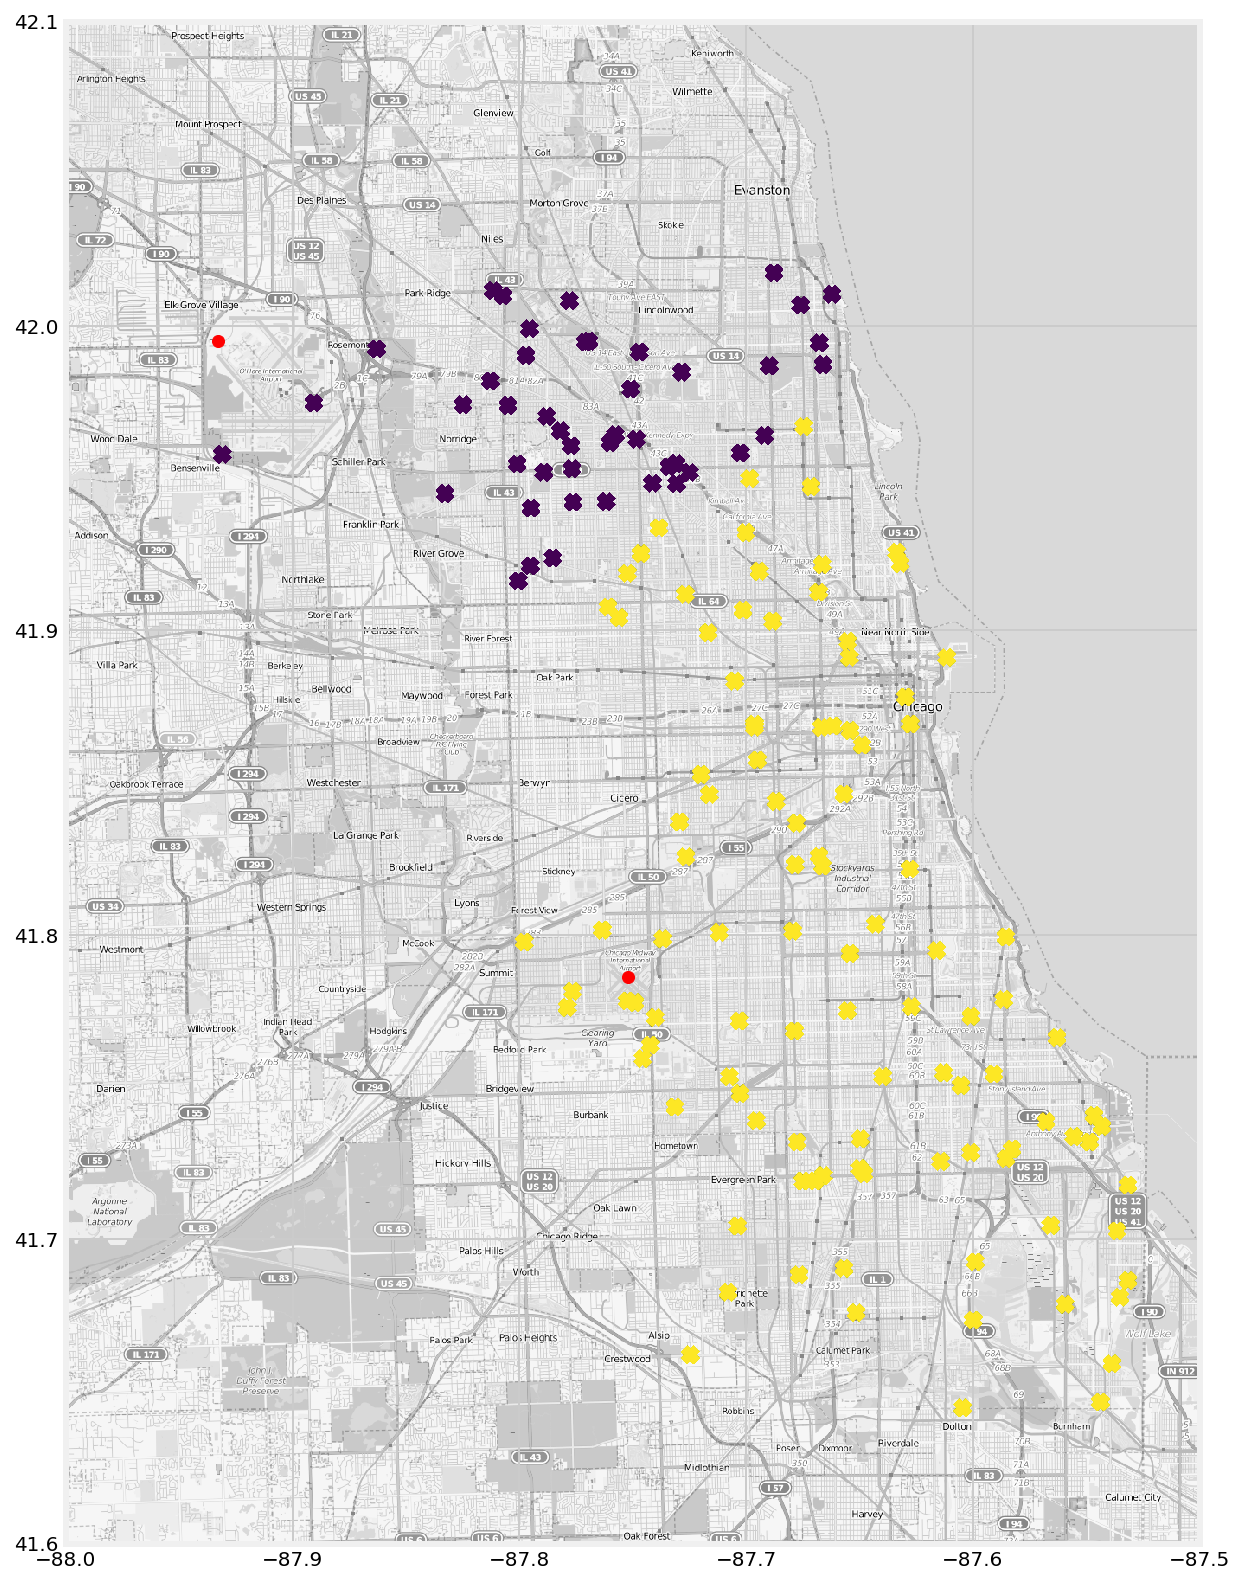

In [10]:
mapdata = np.loadtxt("../data/resources/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(12,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('Greys_r'), 
           extent=lon_lat_box, 
           aspect=aspect)

# locations = aggregated[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(test.Longitude, test.Latitude, c = test.Station ,marker = 'x')
plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c = 'r')

# plt.scatter([-87.933,-87.752],[41.995,41.786], marker = 'o', c='red')
# plt.scatter(locations[:,0], locations[:,1], marker='x', c='yellow')

# Add this when copying to a script on Kaggle:
plt.savefig('../images/train_mapped_to_weather_stations.png')

In [11]:
test.head()

,Id,Date,Species,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1
1,2,2008-06-11,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1
2,3,2008-06-11,CULEX PIPIENS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1
3,4,2008-06-11,CULEX SALINARIUS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1
4,5,2008-06-11,CULEX TERRITANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1


In [12]:
weather.head(2)

,date,year,month,week,daylight,Tmax,Tmin,Tavg,Depart,DewPoint,...,Depart_wkly_lag21,DewPoint_wkly_lag21,WetBulb_wkly_lag21,PrecipTotal_wkly_lag21,StnPressure_wkly_lag21,SeaLevel_wkly_lag21,ResultSpeed_wkly_lag21,ResultDir_wkly_lag21,AvgSpeed_wkly_lag21,Station
0,2007-05-01,2007,5,18,0 days 14:01:00.000000000,83,50,67,14,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2007-05-02,2007,5,18,0 days 14:03:00.000000000,59,42,51,-3,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [13]:
weather.rename(columns={'date':'Date'},inplace=True)

In [14]:
weather.head(2)

,Date,year,month,week,daylight,Tmax,Tmin,Tavg,Depart,DewPoint,...,Depart_wkly_lag21,DewPoint_wkly_lag21,WetBulb_wkly_lag21,PrecipTotal_wkly_lag21,StnPressure_wkly_lag21,SeaLevel_wkly_lag21,ResultSpeed_wkly_lag21,ResultDir_wkly_lag21,AvgSpeed_wkly_lag21,Station
0,2007-05-01,2007,5,18,0 days 14:01:00.000000000,83,50,67,14,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2007-05-02,2007,5,18,0 days 14:03:00.000000000,59,42,51,-3,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [15]:
spray.head(2)

,Date,Latitude,Longitude,Year,Month,Day,Week
95,2011-07-09,41.981433,-87.787777,2011,7,9,27
96,2011-07-09,41.980998,-87.787778,2011,7,9,27


In [16]:
spray = spray[['Date', 'Latitude', 'Longitude','Week']]

In [17]:
spray.head(2)

,Date,Latitude,Longitude,Week
95,2011-07-09,41.981433,-87.787777,27
96,2011-07-09,41.980998,-87.787778,27


In [18]:
test['Date'] = pd.to_datetime(test['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])
spray['Date'] = pd.to_datetime(spray['Date'])

In [19]:
merge_tw = pd.merge(test,weather,on=['Station','Date'], how = 'left')

In [20]:
print(merge_tw.shape)
merge_tw.head()

(116293, 73)


,Id,Date,Species,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,year,...,Tavg_wkly_lag21,Depart_wkly_lag21,DewPoint_wkly_lag21,WetBulb_wkly_lag21,PrecipTotal_wkly_lag21,StnPressure_wkly_lag21,SeaLevel_wkly_lag21,ResultSpeed_wkly_lag21,ResultDir_wkly_lag21,AvgSpeed_wkly_lag21
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,54.428571,-5.285714,37.714286,46.857143,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714
1,2,2008-06-11,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,54.428571,-5.285714,37.714286,46.857143,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714
2,3,2008-06-11,CULEX PIPIENS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,54.428571,-5.285714,37.714286,46.857143,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714
3,4,2008-06-11,CULEX SALINARIUS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,54.428571,-5.285714,37.714286,46.857143,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714
4,5,2008-06-11,CULEX TERRITANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,54.428571,-5.285714,37.714286,46.857143,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714


In [21]:
spray_clusters = pd.read_csv('../data/cluster_to_merge.csv', index_col='Unnamed: 0')
cluster_to_merge = spray_clusters
cluster_to_merge

,Date,midpt_Lat,midpt_Lon,Cluster
95,2011-07-09,41.982275,-87.809953,0
13911,2013-05-09,41.986852,-87.683572,1
14606,2013-05-09,41.986852,-87.683572,2
2209,2013-07-17,42.007177,-87.811135,4
2537,2013-07-17,42.007177,-87.811135,3
4411,2013-07-25,41.728866,-87.649709,5
6018,2013-08-08,41.954535,-87.722879,6
7213,2013-08-15,41.931467,-87.697035,7
10022,2013-08-22,41.927604,-87.783040,8
10867,2013-08-22,41.927604,-87.783040,9


In [22]:
indiv_traps = merge_tw.groupby(['Latitude','Longitude'])['Trap'].agg(['unique','count'])
indiv_traps.reset_index(inplace=True)
indiv_traps.shape

(151, 4)

In [23]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 # Radius of earth in kilometers
    return c * r

In [24]:
indiv_traps['key'] = 1
cluster_to_merge['key'] = 1

df = indiv_traps.merge(cluster_to_merge,on='key')
del df['key']
df['distance'] = df.apply(lambda x: haversine(x['Longitude'],x['Latitude'],x['midpt_Lon'],x['midpt_Lat']),axis=1)
df.Cluster.value_counts()
df.head()

df = df.loc[df.groupby(['Longitude','Latitude'])["distance"].idxmin()]
# df.Cluster.value_counts()
# df.shape
df.head()

,Latitude,Longitude,unique,count,Date,midpt_Lat,midpt_Lon,Cluster,distance
1440,41.957799,-87.930995,[T903],784,2011-07-09,41.982275,-87.809953,0,10.381807
1584,41.974689,-87.890615,[T900],1468,2011-07-09,41.982275,-87.809953,0,6.728237
1680,41.992478,-87.862995,[T009],768,2011-07-09,41.982275,-87.809953,0,4.533387
1316,41.944869,-87.832763,[T011],814,2013-08-22,41.927604,-87.783040,8,4.543842
1572,41.974089,-87.824812,[T015],760,2011-07-09,41.982275,-87.809953,0,1.530481


In [25]:
df_mapped = df[df['distance'] < 2.5]
df_mapped.Cluster.value_counts()

6     7
5     7
8     6
1     5
0     5
11    4
10    3
7     3
4     3
Name: Cluster, dtype: int64

In [26]:
merge_all = pd.merge(merge_tw,df_mapped[['Latitude','Longitude','midpt_Lat','midpt_Lon','Cluster','Date']], on = ['Latitude','Longitude'], how = 'left')

In [27]:
merge_all.head(2)

,Id,Date_x,Species,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,year,...,PrecipTotal_wkly_lag21,StnPressure_wkly_lag21,SeaLevel_wkly_lag21,ResultSpeed_wkly_lag21,ResultDir_wkly_lag21,AvgSpeed_wkly_lag21,midpt_Lat,midpt_Lon,Cluster,Date_y
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714,NaN,NaN,NaN,NaN
1,2,2008-06-11,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714,NaN,NaN,NaN,NaN


In [28]:
merge_all.rename(columns = {'Date_x':'Test Date', 'Date_y': 'Spray Date'}, inplace=True)

In [29]:
a = merge_all.shape[0] - merge_all['Spray Date'].isnull().sum()
b = merge_all.Cluster.isnull().sum()
print('{} out of {} observations in the test data have been mapped to a spray location each.'.format(a, b))

32863 out of 83430 observations in the test data have been mapped to a spray location each.


In [30]:
merge_all.head()

,Id,Test Date,Species,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Station,year,...,PrecipTotal_wkly_lag21,StnPressure_wkly_lag21,SeaLevel_wkly_lag21,ResultSpeed_wkly_lag21,ResultDir_wkly_lag21,AvgSpeed_wkly_lag21,midpt_Lat,midpt_Lon,Cluster,Spray Date
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714,NaN,NaN,NaN,NaN
1,2,2008-06-11,CULEX RESTUANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714,NaN,NaN,NaN,NaN
2,3,2008-06-11,CULEX PIPIENS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714,NaN,NaN,NaN,NaN
3,4,2008-06-11,CULEX SALINARIUS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714,NaN,NaN,NaN,NaN
4,5,2008-06-11,CULEX TERRITANS,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,2008,...,0.017143,29.018571,29.744286,7.214286,23.428571,9.185714,NaN,NaN,NaN,NaN


In [31]:
species_dummies = pd.get_dummies(merge_all.Species, drop_first=False)
merge_all = pd.concat([merge_all, species_dummies], axis=1)

In [32]:
merge_all.shape

(116293, 85)

In [33]:
merge_all['Test Date'] = pd.to_datetime(merge_all['Test Date'])
merge_all['Spray Date'] = pd.to_datetime(merge_all['Spray Date'])

In [34]:
merge_all['Days between Spray and Test'] = (merge_all['Test Date'] - merge_all['Spray Date']).dt.days - 7

In [35]:
# Assign value of 1 to 'Has been Sprayed' feature if 'Day between Spray and Test' > 0 and < 30
merge_all['Has been Sprayed'] = np.where((merge_all['Days between Spray and Test'] > 0) & (merge_all['Days between Spray and Test'] < 30), 1, 0)

In [36]:
merge_all['Has been Sprayed'].value_counts()

0    116293
Name: Has been Sprayed, dtype: int64

In [37]:
merge_all['Hour'] = merge_all.daylight.str[-18:-16]
merge_all['Minute'] = merge_all.daylight.str[-15:-13]
merge_all['Second'] = merge_all.daylight.str[-12:-10]

In [38]:
merge_all['Hour'] = merge_all['Hour'].astype(float)
merge_all['Minute'] = merge_all['Minute'].astype(float)
merge_all['Second'] = merge_all['Second'].astype(float)

In [39]:
merge_all['Daylight Hours'] = round((merge_all.Hour + merge_all.Minute/60 + merge_all.Second/3600),0)

In [40]:
merge_all['Daylight Hours'].value_counts()

15.0    53898
14.0    25817
13.0    22016
12.0    14562
Name: Daylight Hours, dtype: int64

In [41]:
merge_all['Daylight Hours'].dtype

dtype('float64')

In [42]:
merge_all.columns

Index(['Id', 'Test Date', 'Species', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'Station', 'year', 'month',
       'week', 'daylight', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Tmax_wkly', 'Tmin_wkly', 'Tavg_wkly',
       'Depart_wkly', 'DewPoint_wkly', 'WetBulb_wkly', 'PrecipTotal_wkly',
       'StnPressure_wkly', 'SeaLevel_wkly', 'ResultSpeed_wkly',
       'ResultDir_wkly', 'AvgSpeed_wkly', 'Tmax_wkly_lag7', 'Tmin_wkly_lag7',
       'Tavg_wkly_lag7', 'Depart_wkly_lag7', 'DewPoint_wkly_lag7',
       'WetBulb_wkly_lag7', 'PrecipTotal_wkly_lag7', 'StnPressure_wkly_lag7',
       'SeaLevel_wkly_lag7', 'ResultSpeed_wkly_lag7', 'ResultDir_wkly_lag7',
       'AvgSpeed_wkly_lag7', 'Tmax_wkly_lag14', 'Tmin_wkly_lag14',
       'Tavg_wkly_lag14', 'Depart_wkly_lag14', 'DewPoint_wkly_lag14',
       'WetBulb_wkly_lag14', 'PrecipTotal_wkly_lag14',


In [43]:
merge_all.to_csv('../data/merged_test.csv')

#### Visualize data

Our classes are very unbalanced for our target variable, WnvPresent. We will keep this in mind when modeling, since our models will be less accurate with unbalanced classes. In order to solve this we can look at the following options before modeling:
* Oversampling the WnvPresent == 1 class
* Bootstrapping
* Stratifying

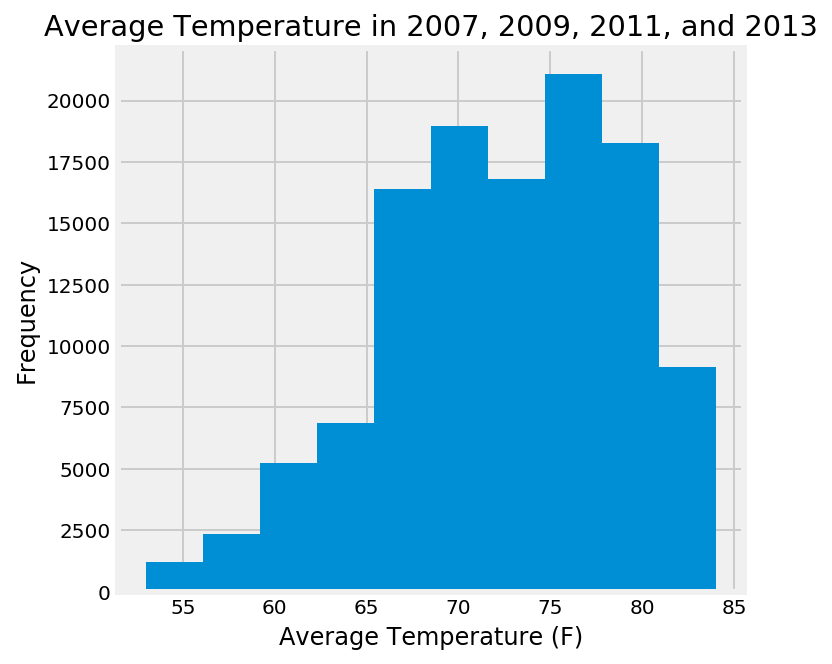

In [44]:
# Average temperature distribution 
fig = plt.figure(figsize = (5,5))
merge_all['Tavg'].plot(kind='hist')
plt.xlabel('Average Temperature (F)')
plt.title('Average Temperature in 2007, 2009, 2011, and 2013');

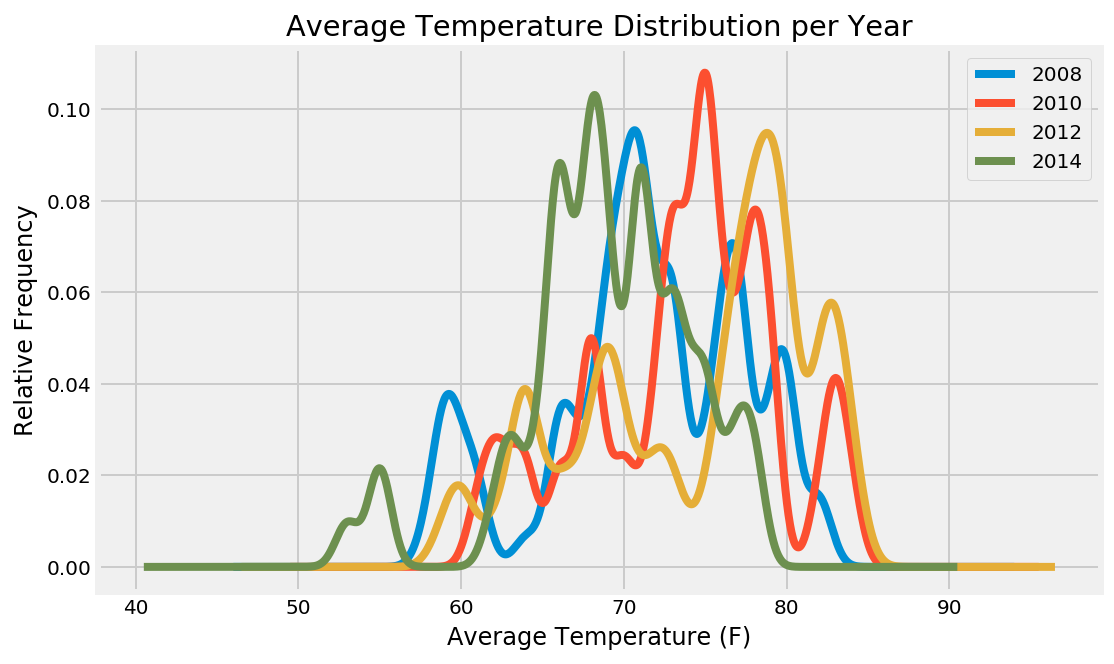

In [45]:
# Average temperature distributions per year 
fig = plt.figure(figsize = (8,5))
merge_all.groupby('year')['Tavg'].plot(kind = 'kde')
plt.xlabel("Average Temperature (F)")
plt.ylabel('Relative Frequency')
plt.title('Average Temperature Distribution per Year')
plt.legend();

In [46]:
# Determine median temperature per year 
merge_all.groupby('year')['Tavg'].median()

year
2008    71
2010    75
2012    77
2014    69
Name: Tavg, dtype: int64

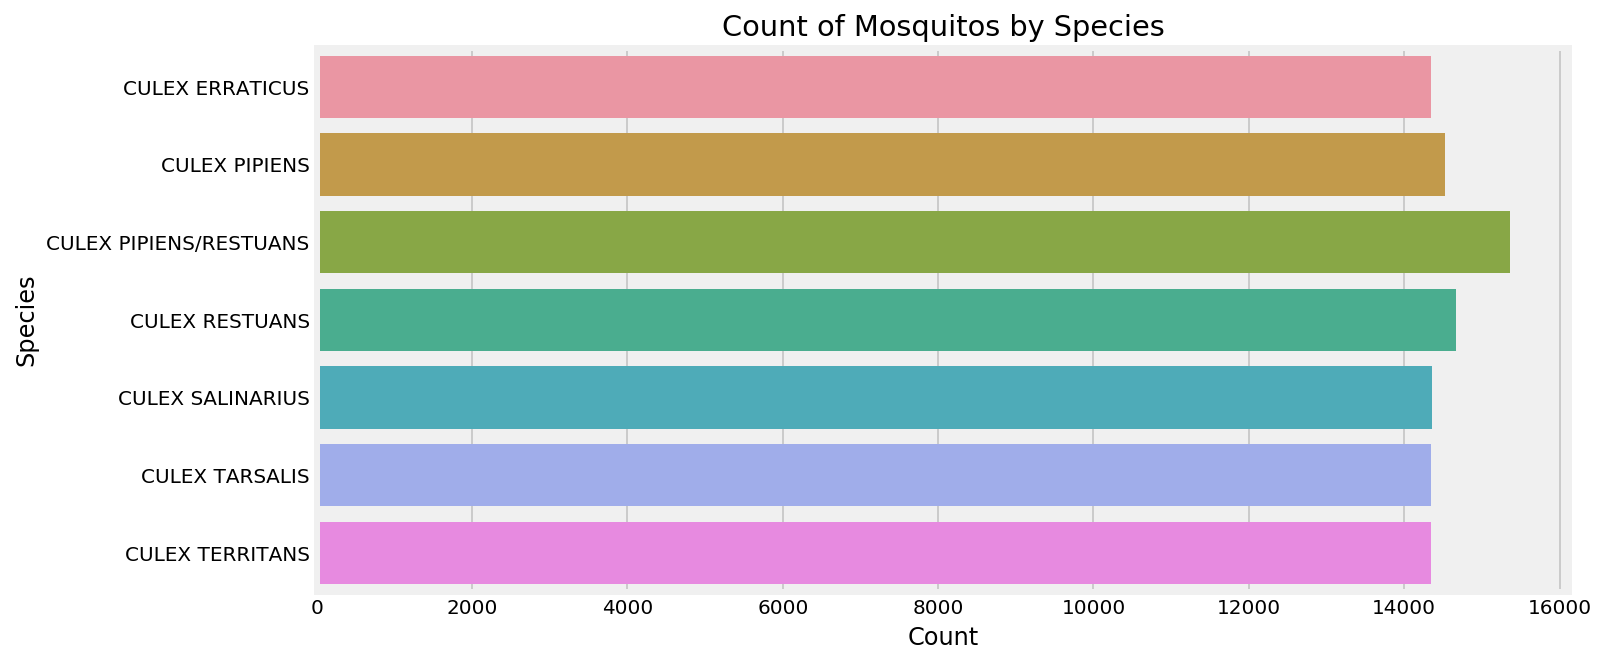

In [47]:
# Plot of species counts
species = [col for col in merge_all.columns if col.startswith("CULEX")]
fig = plt.figure(figsize = (10, 5))
sns.barplot(x = merge_all[species].sum(), y = species)
plt.xlabel('Count')
plt.ylabel('Species')
plt.title('Count of Mosquitos by Species');

Culex Pipiens and Restuans represent the majority of species by count. 

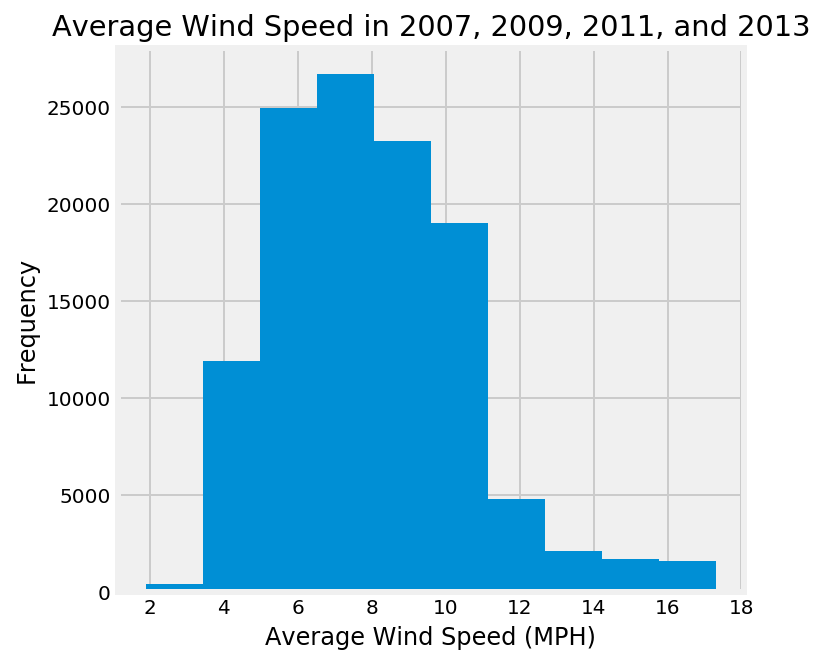

In [48]:
# Average wind speed distribution 
fig = plt.figure(figsize = (5,5))
merge_all['AvgSpeed'].plot(kind = 'hist')
plt.xlabel('Average Wind Speed (MPH)')
plt.title('Average Wind Speed in 2007, 2009, 2011, and 2013');

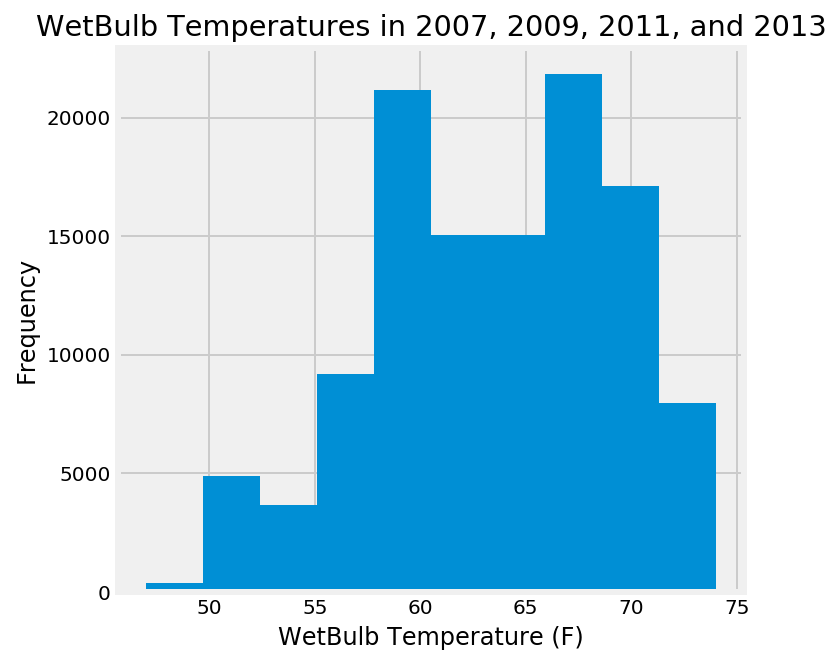

In [49]:
# WetBulb Distribution - wetbulb indicates humidity 
fig = plt.figure(figsize = (5,5))
merge_all['WetBulb'].plot(kind='hist')
plt.xlabel('WetBulb Temperature (F)')
plt.title('WetBulb Temperatures in 2007, 2009, 2011, and 2013');

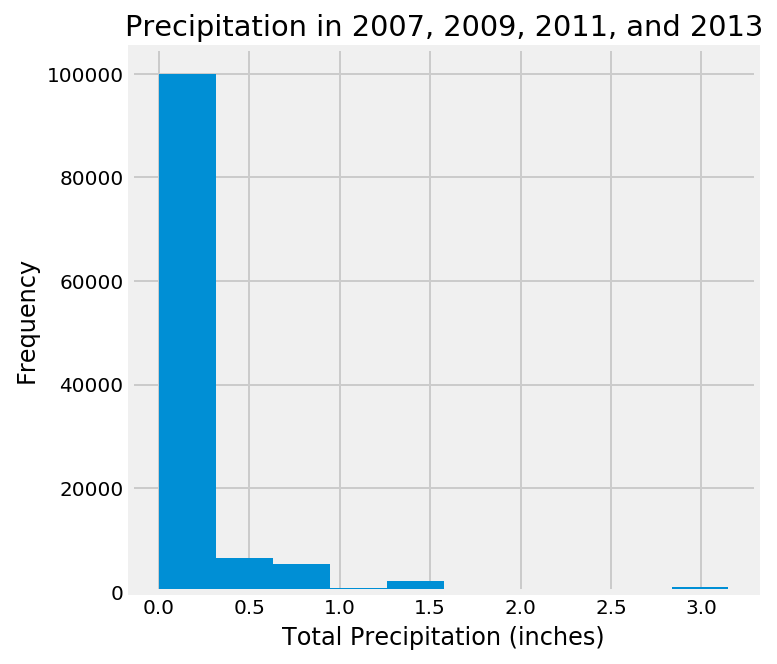

In [50]:
# Precipitation Distribution 
fig = plt.figure(figsize = (5,5))
merge_all['PrecipTotal'].plot(kind='hist')
plt.xlabel('Total Precipitation (inches)')
plt.title('Precipitation in 2007, 2009, 2011, and 2013');

Most days seem to be dry or have very little precipitation